# **Bank Churn Prediction**


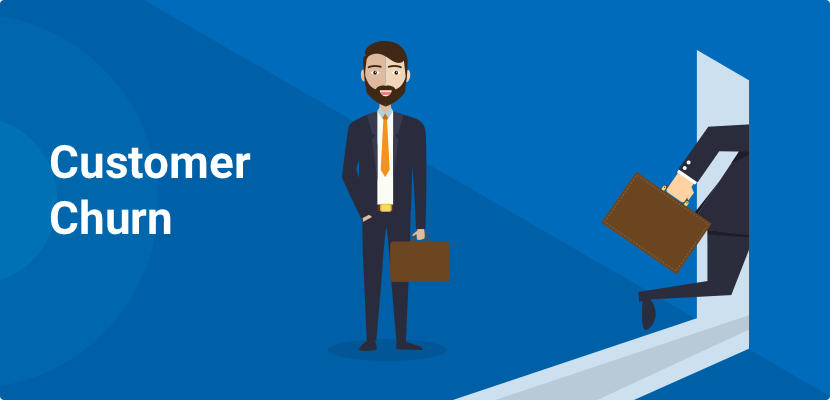

**Import the libraries**

In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
%matplotlib inline

import imblearn # SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

**Read the file**

In [11]:
bank_churner = pd.read_csv('/content/BankChurn_Data/BankChurners.csv')
bank_churner.shape

(10127, 21)

**Dataset Information**

In [12]:
bank_churner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [13]:
display(bank_churner.describe().style.set_properties(**{"background-color": "#b2c4cc"
,"color": "black", "border-color": "black", "font-size":"8pt", 'width': 200}))
display(bank_churner.head(5).style.set_properties(**{"background-color": "#b2c4cc"
,"color": "black", "border-color": "black", "font-size":"8pt", 'width': 200}))

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,739177606.333663,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,36903783.450231,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,708082083.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,713036770.500000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,717926358.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,773143533.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,828343083.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000000,777,11914.000000,1.335000,1144,42,1.625000,0.061000
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000000,864,7392.000000,1.541000,1291,33,3.714000,0.105000
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000000,0,3418.000000,2.594000,1887,20,2.333000,0.000000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.000000,2517,796.000000,1.405000,1171,20,2.333000,0.760000
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000000,0,4716.000000,2.175000,816,28,2.500000,0.000000


In [14]:
bank_churner.isnull().sum() # There is no missing value in this dataset

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [15]:
# check the precentage of 'Unknown' strings in three columns
print(f"\nUnknown Values %:\n{bank_churner.apply(lambda x: sum(x=='Unknown') / len(bank_churner))}")


Unknown Values %:
CLIENTNUM                   0.000000
Attrition_Flag              0.000000
Customer_Age                0.000000
Gender                      0.000000
Dependent_count             0.000000
Education_Level             0.149995
Marital_Status              0.073961
Income_Category             0.109805
Card_Category               0.000000
Months_on_book              0.000000
Total_Relationship_Count    0.000000
Months_Inactive_12_mon      0.000000
Contacts_Count_12_mon       0.000000
Credit_Limit                0.000000
Total_Revolving_Bal         0.000000
Avg_Open_To_Buy             0.000000
Total_Amt_Chng_Q4_Q1        0.000000
Total_Trans_Amt             0.000000
Total_Trans_Ct              0.000000
Total_Ct_Chng_Q4_Q1         0.000000
Avg_Utilization_Ratio       0.000000
dtype: float64


There are Unknow strings in education level, marital status and income category

In [16]:
bank_churner[(bank_churner['Income_Category']!='Unknown') 
            & (bank_churner['Education_Level']!='Unknown') 
            & (bank_churner['Marital_Status']!='Unknown')]['Attrition_Flag'].value_counts()

Existing Customer    5968
Attrited Customer    1113
Name: Attrition_Flag, dtype: int64

In [17]:
# drop the 'CLIENTNUM' column
bank_churner.drop(columns = bank_churner.columns[0], axis=1, inplace=True)

**Data visualisation**

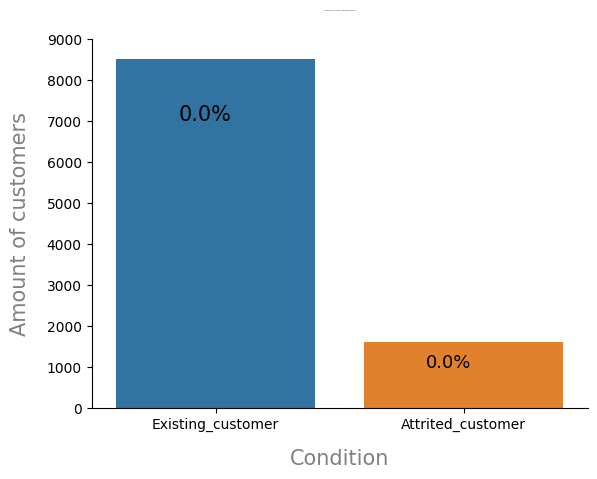

In [18]:
# plot the graph to see the proportion of customers
existing_customer = bank_churner[bank_churner['Attrition_Flag'] == 0]['Attrition_Flag'].count() / bank_churner.shape[0] * 100
attrited_customer = bank_churner[bank_churner['Attrition_Flag'] == 1]['Attrition_Flag'].count() / bank_churner.shape[0] * 100

sns.countplot(x='Attrition_Flag', data = bank_churner)
plt.xticks([0, 1], ['Existing_customer', 'Attrited_customer'])
plt.xlabel('Condition', size=15, labelpad=12, color='grey')
plt.ylabel('Amount of customers', size=15, labelpad=12, color='grey')
plt.title("Proportion of existing and attrited customers", size=1, pad=20)
plt.ylim(0, 9000)
plt.text(-0.15, 7000, f"{round(existing_customer, 2)}%", fontsize=15)
plt.text(0.85, 1000, f"{round(attrited_customer, 2)}%", fontsize=13)
sns.despine()

As the bar chart illustrates the imbalance of data. This chart can be observed that only 16.07% of the customers have churned.

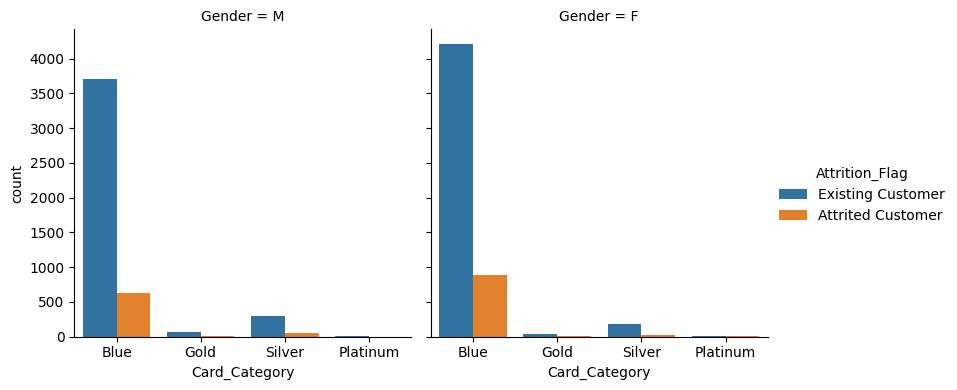

In [19]:
sns.catplot(x="Card_Category", hue="Attrition_Flag", col="Gender",
                data=bank_churner, kind="count",
                height=4, aspect=1);

This charts demonstrate that the marjority of card type is blue. Whereas, a few people are having silver card type (less than 300 people) and very few gold type (less than 100 people). However, we need more information about this dataset



<Axes: xlabel='Income_Category', ylabel='Count'>

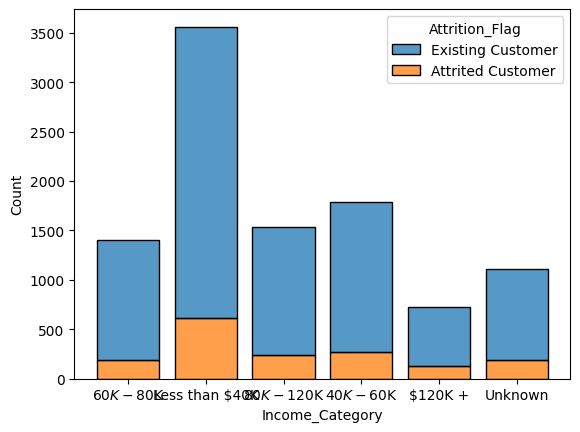

In [20]:
sns.histplot(data=bank_churner, x="Income_Category",hue="Attrition_Flag", multiple="stack", shrink = .8)

<Axes: xlabel='Customer_Age', ylabel='Count'>

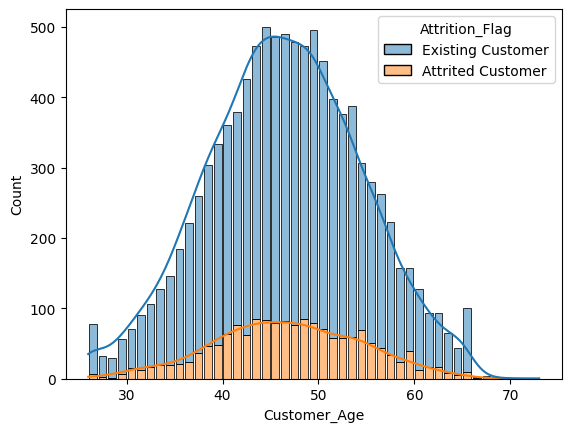

In [21]:
sns.histplot(data=bank_churner, x="Customer_Age",hue="Attrition_Flag", bins = 'auto',multiple="stack", shrink = .8,kde = True)

This is a very good information about the age of customers who are still retained and attrited.

In [22]:
# the mean of the custmer age
round(bank_churner.Customer_Age.mean())

46

**Binning [Customer Age Binning]** 

In [23]:
bank_churner['Customer_Age_binning'] = pd.cut(np.array(bank_churner['Customer_Age']), 
                                              bins=int(bank_churner.Customer_Age.std()),
                                              precision=0)

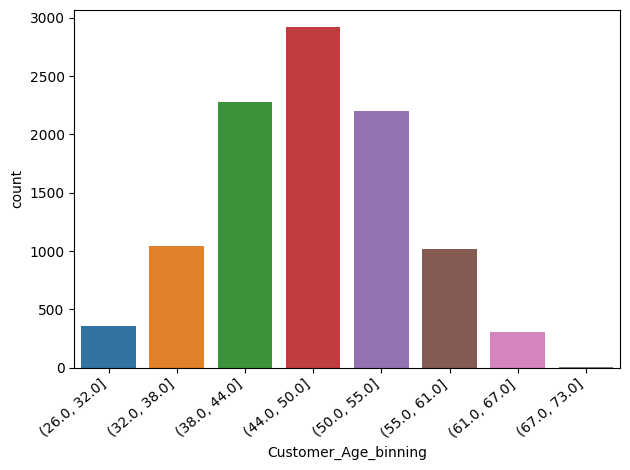

In [24]:
ax = sns.countplot(x="Customer_Age_binning", data = bank_churner)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [25]:
# drop the column after using for ploting the customer_age_bining
bank_churner = bank_churner.drop('Customer_Age_binning', axis = 1)

In [26]:
# All columns
bc_allcols = bank_churner.columns
bc_allcols
# numeric columns
bc_num_cols = bank_churner._get_numeric_data().columns
bc_num_cols
# categegorical_columns
bc_cat_cols = list(set(bc_allcols) - set(bc_num_cols))
print(bc_cat_cols)

['Marital_Status', 'Education_Level', 'Income_Category', 'Gender', 'Card_Category', 'Attrition_Flag']


Utilise the data column by dividing into two sectors to visualise. Firstly, saving the all column data. Secondly, dividing and storing two groups as numeric column and categorical column.

In [27]:
def pltcrosstab(cat, df):
    
    fig, axis = plt.subplots((len(cat) // 3), 3, figsize=(16,8))  
    fig.tight_layout()
    index = 0
    sns.set()
    for i in range((len(cat) // 3)):
            
        for j in range(3):

            if index == len(cat):
                break
            
            ax = pd.crosstab(df[cat[index]], df['Attrition_Flag']).plot(kind='bar', ax=axis[i][j])
        
            for item in ax.get_xticklabels():
                item.set_rotation(20)

            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width(), height + 3, '{:1.2f}%'.format(height/len(df)*100), ha="center", fontsize=8) 
            
            index += 1
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

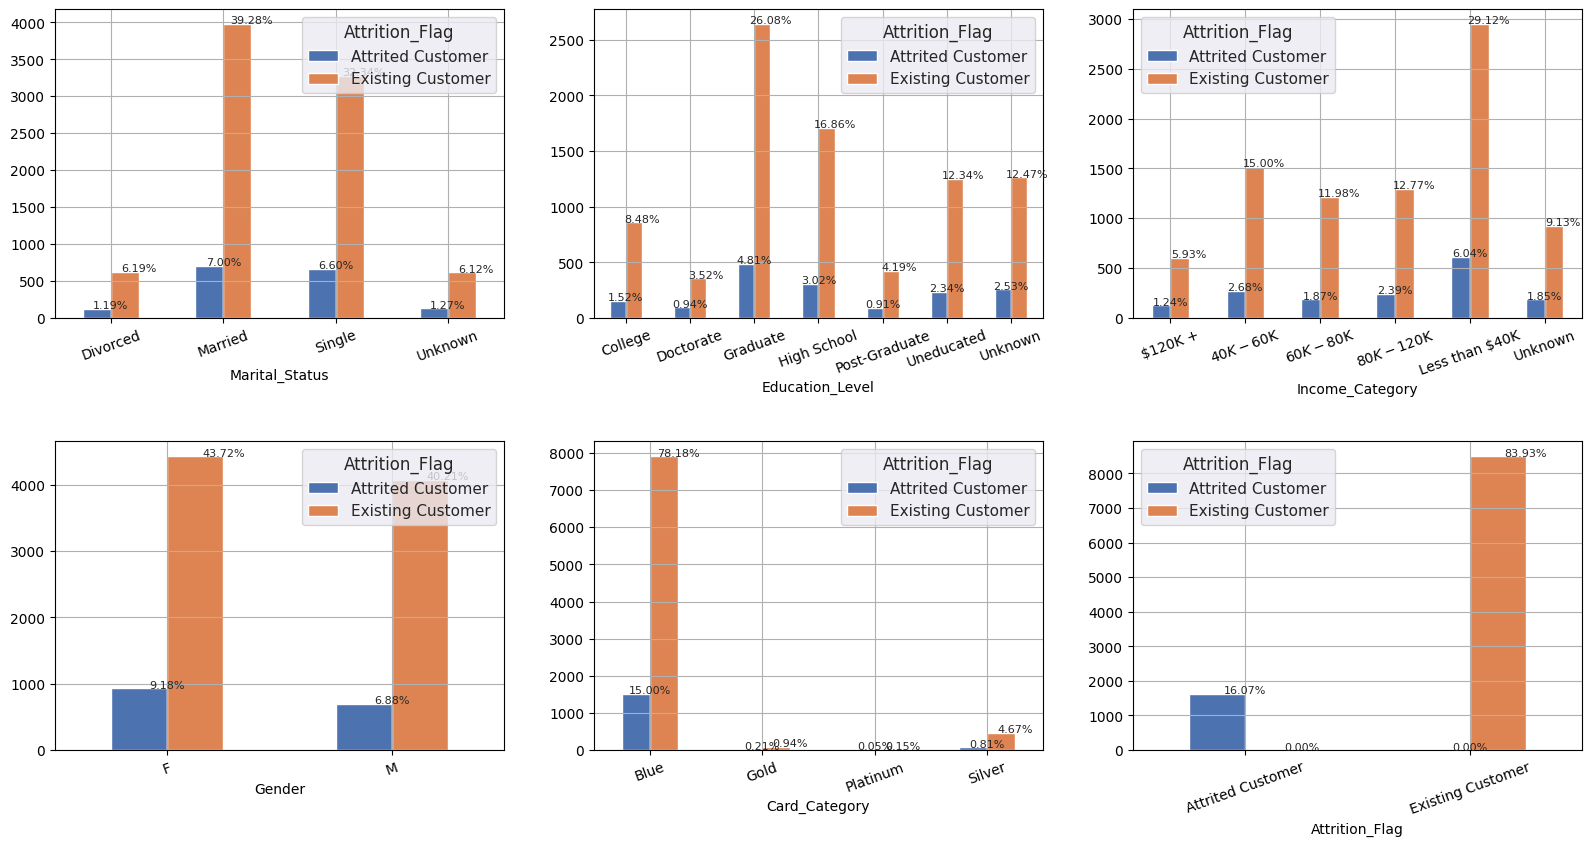

In [28]:
pltcrosstab(bc_cat_cols, bank_churner);

Have a look at the categorical group, the first thing that can be observed is that the data shows the imbalance.

array([[<Axes: title={'center': 'Customer_Age'}>,
        <Axes: title={'center': 'Dependent_count'}>,
        <Axes: title={'center': 'Months_on_book'}>,
        <Axes: title={'center': 'Total_Relationship_Count'}>],
       [<Axes: title={'center': 'Months_Inactive_12_mon'}>,
        <Axes: title={'center': 'Contacts_Count_12_mon'}>,
        <Axes: title={'center': 'Credit_Limit'}>,
        <Axes: title={'center': 'Total_Revolving_Bal'}>],
       [<Axes: title={'center': 'Avg_Open_To_Buy'}>,
        <Axes: title={'center': 'Total_Amt_Chng_Q4_Q1'}>,
        <Axes: title={'center': 'Total_Trans_Amt'}>,
        <Axes: title={'center': 'Total_Trans_Ct'}>],
       [<Axes: title={'center': 'Total_Ct_Chng_Q4_Q1'}>,
        <Axes: title={'center': 'Avg_Utilization_Ratio'}>, <Axes: >,
        <Axes: >]], dtype=object)

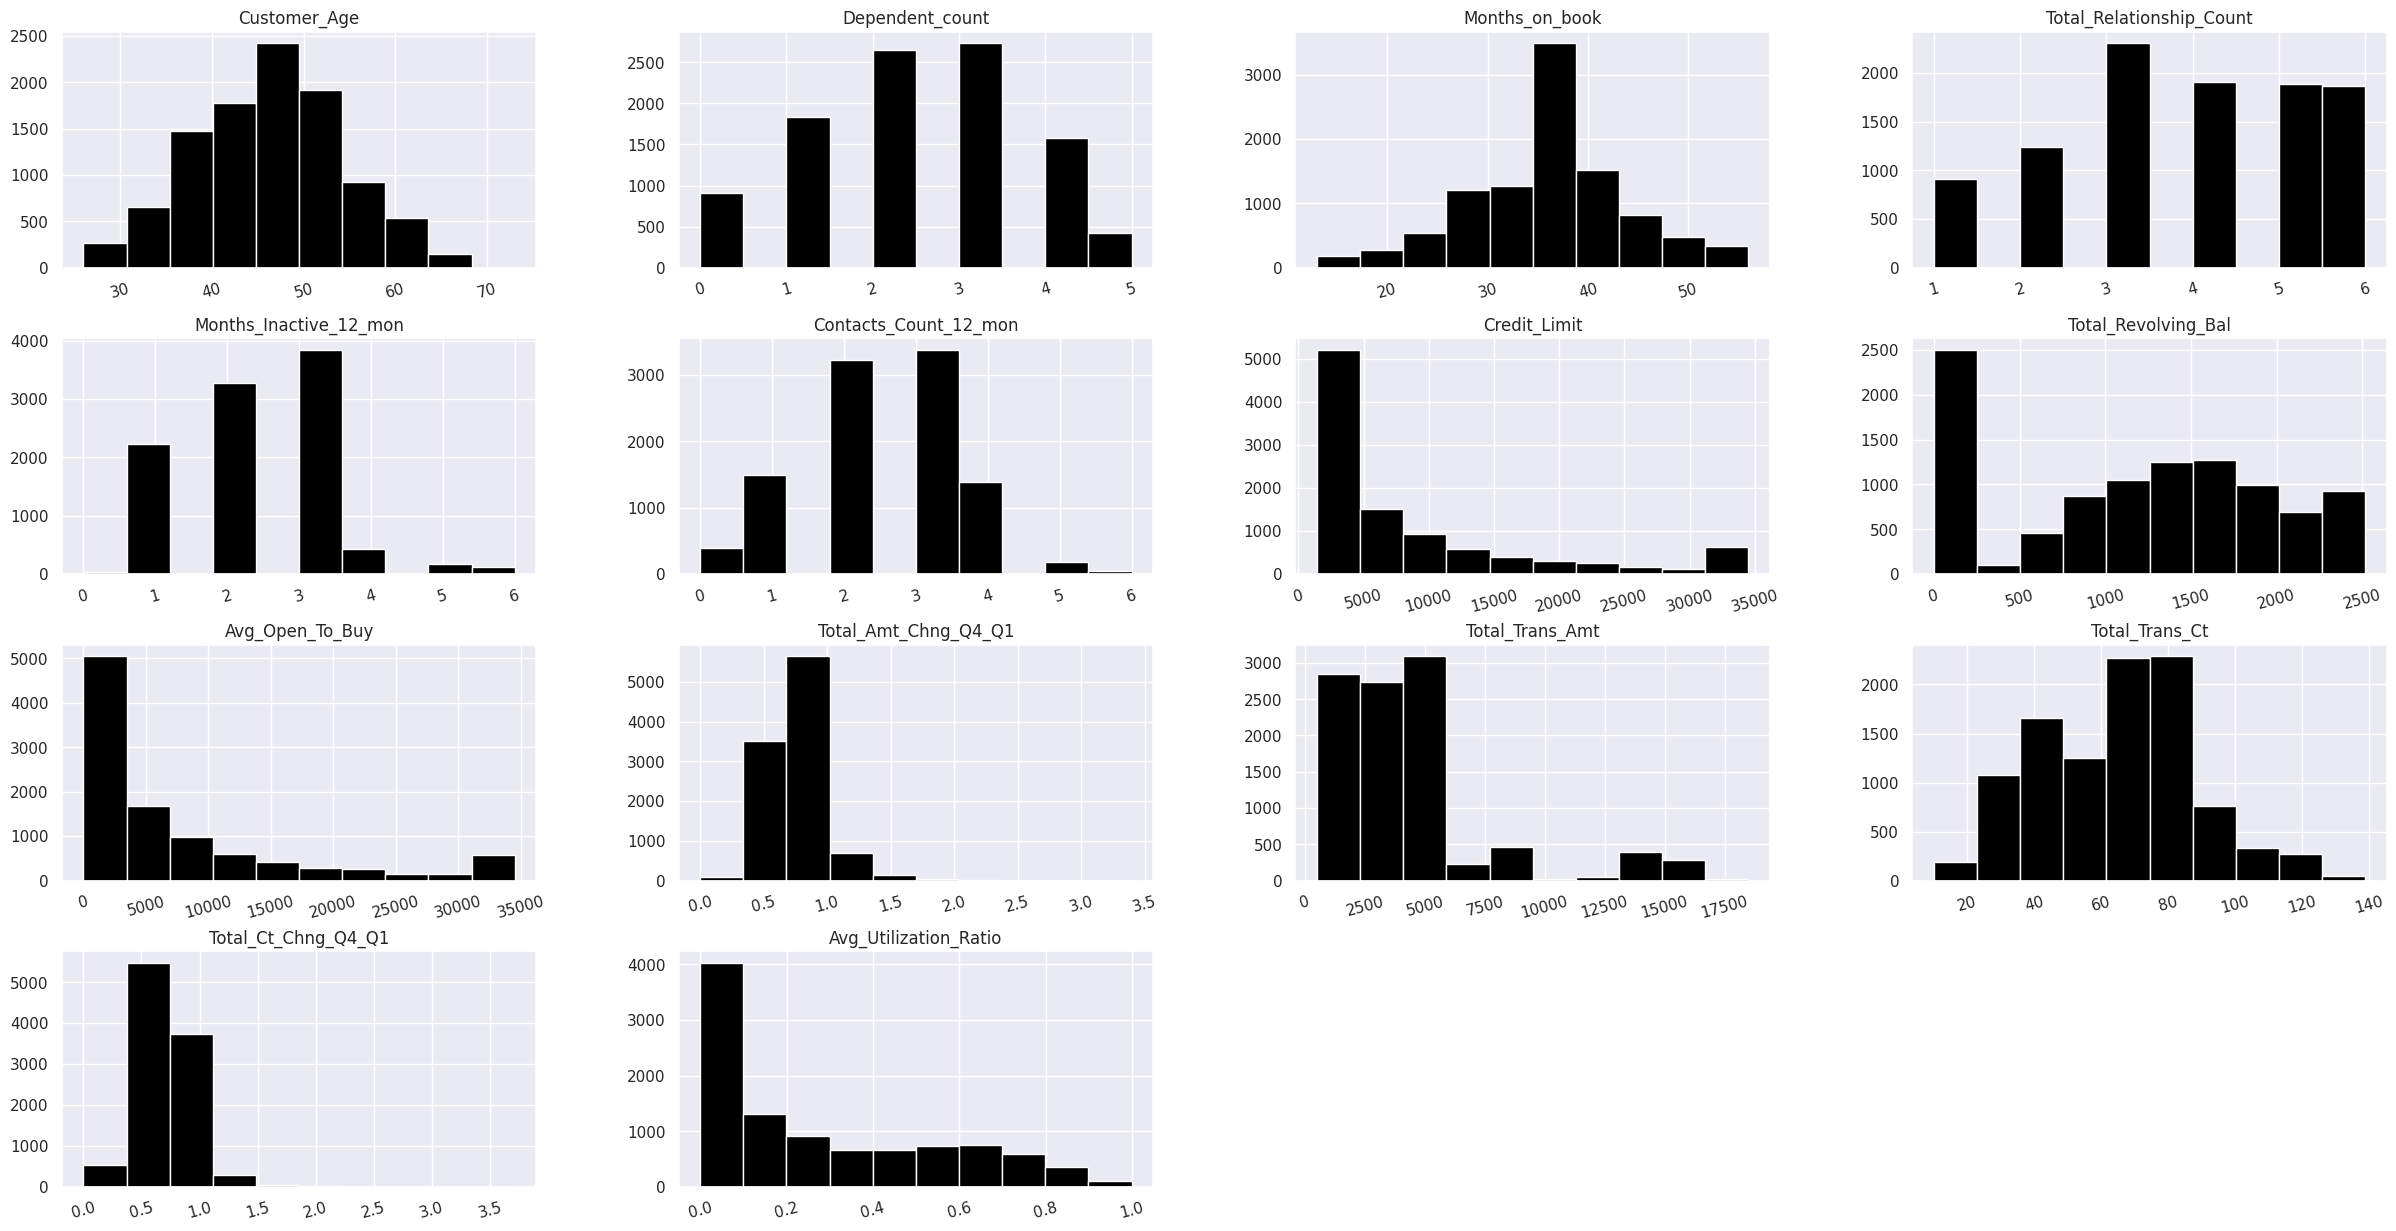

In [29]:
bank_churner.hist(figsize=(30,15), xrot=15, color = 'black',bins=int(bank_churner.shape[0]**0.25))

This is more information for the numeric group

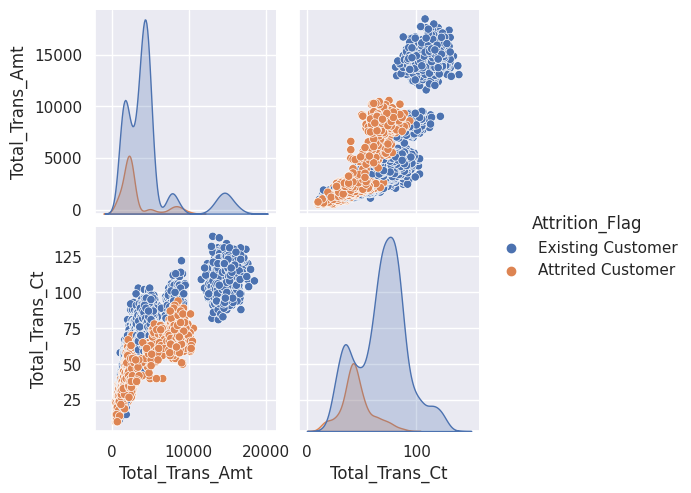

In [30]:
sns.pairplot(bank_churner, vars=['Total_Trans_Amt','Total_Trans_Ct'], hue='Attrition_Flag', height=2.5)

The pairplot of numerical columns, people who churned from credit card service, had less transaction count and transaction amount.

**Replacing numeric 0 and 1 to the target parameter**

In [31]:
# replace existing customer with 0 and attited customer with 1
bank_churner['Attrition_Flag'].replace(['Existing Customer', 'Attrited Customer']
                                       , [0,1], inplace = True)

Converting type of categorical column to integer before checking the corelation

In [32]:
# using pd.factorize to convert datatype to int
cat_bc = bank_churner[bc_cat_cols].apply(lambda x : pd.factorize(x)[0])
cat_bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Marital_Status   10127 non-null  int64
 1   Education_Level  10127 non-null  int64
 2   Income_Category  10127 non-null  int64
 3   Gender           10127 non-null  int64
 4   Card_Category    10127 non-null  int64
 5   Attrition_Flag   10127 non-null  int64
dtypes: int64(6)
memory usage: 474.8 KB


In [33]:
bc_concat = pd.concat([cat_bc, bank_churner[bc_num_cols]], axis=1)
bc_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Marital_Status            10127 non-null  int64  
 1   Education_Level           10127 non-null  int64  
 2   Income_Category           10127 non-null  int64  
 3   Gender                    10127 non-null  int64  
 4   Card_Category             10127 non-null  int64  
 5   Attrition_Flag            10127 non-null  int64  
 6   Customer_Age              10127 non-null  int64  
 7   Dependent_count           10127 non-null  int64  
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

**Checking the corelation after all data types are numeric**

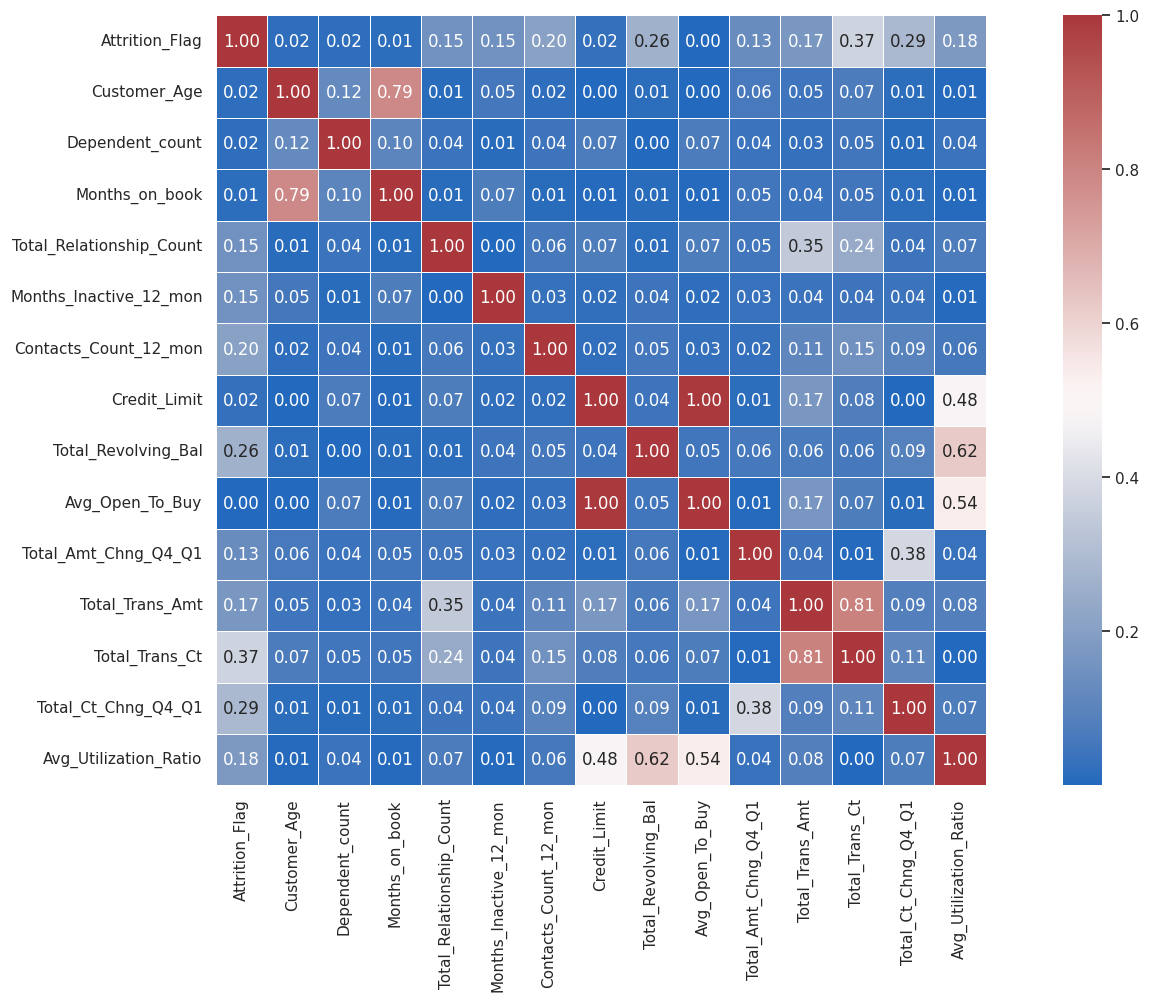

In [34]:
bc_num_cols = bank_churner._get_numeric_data().columns
bc_corr = bank_churner.loc[:, bc_num_cols].corr()

plt.figure(figsize=(20,10))
sns.heatmap(bc_corr.abs(), linewidths = 0.5,cmap='vlag',square=True,annot=True, fmt='.2f')
plt.show()

**Performing Chi 2**

In [35]:
# performing chi2
from scipy.stats import chi2_contingency
factors_paired = [(i,j) for i in bc_concat.columns.values for j in bc_concat.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(bc_concat[f[0]], bc_concat[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:
        chi2.append(0)
        p_values.append(0)
n_features = len(bc_concat.columns)
chi2 = np.array(chi2).reshape((n_features, n_features)) 
chi2 = pd.DataFrame(chi2, index=bc_concat.columns.values, columns=bc_concat.columns.values) 
# p values is what will help us to decide dependent variables or independent variables
p_values = np.array(p_values).reshape((n_features, n_features))
p_values = pd.DataFrame(p_values, index=bc_concat.columns.values, columns=bc_concat.columns.values)

In [36]:
p_values.head()

,Marital_Status,Education_Level,Income_Category,Gender,Card_Category,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Marital_Status,0.000000,0.254514,3.107848e-01,2.752383e-01,1.804597e-04,0.108913,4.367050e-33,1.098223e-06,2.613670e-04,1.391759e-02,0.356316,3.590232e-01,3.431139e-02,0.980538,3.888958e-02,0.999387,2.560844e-02,7.644927e-21,0.301154,8.576516e-01
Education_Level,0.254514,0.000000,3.655347e-02,2.949785e-01,4.803408e-01,0.051489,8.155788e-02,4.647014e-01,4.482955e-01,5.037677e-01,0.792384,9.960346e-01,7.685996e-01,0.730030,5.727239e-01,0.728886,7.041956e-01,7.942810e-01,0.031562,6.856923e-01
Income_Category,0.310785,0.036553,0.000000e+00,0.000000e+00,1.210687e-14,0.025002,1.209849e-32,2.360305e-14,7.162656e-09,3.224772e-01,0.043922,8.151353e-02,6.810997e-57,0.218130,7.591089e-44,0.103702,6.623665e-04,2.364812e-07,0.016126,2.863755e-49
Gender,0.275238,0.294979,0.000000e+00,0.000000e+00,3.604858e-16,0.000196,2.743267e-01,5.892609e-01,7.214150e-01,4.933136e-01,0.144431,2.576879e-07,4.565604e-22,0.631900,3.467263e-09,0.771792,5.340260e-05,1.231593e-34,0.012247,2.515724e-95
Card_Category,0.000180,0.480341,1.210687e-14,3.604858e-16,0.000000e+00,0.525238,5.615201e-02,5.753035e-02,8.695887e-01,1.601259e-24,0.654858,2.736751e-01,1.000000e+00,0.002079,2.389046e-129,1.000000,4.333935e-231,2.720540e-60,0.701332,1.526237e-07


In [37]:
# See the correlation of the attition flag column
1 - p_values['Attrition_Flag']

Marital_Status              0.891087
Education_Level             0.948511
Income_Category             0.974998
Gender                      0.999804
Card_Category               0.474762
Attrition_Flag              1.000000
Customer_Age                0.979171
Dependent_count             0.908495
Months_on_book              0.942571
Total_Relationship_Count    1.000000
Months_Inactive_12_mon      1.000000
Contacts_Count_12_mon       1.000000
Credit_Limit                0.346883
Total_Revolving_Bal         1.000000
Avg_Open_To_Buy             0.888031
Total_Amt_Chng_Q4_Q1        1.000000
Total_Trans_Amt             1.000000
Total_Trans_Ct              1.000000
Total_Ct_Chng_Q4_Q1         1.000000
Avg_Utilization_Ratio       1.000000
Name: Attrition_Flag, dtype: float64

Attribute selection (15 features):

* Income_Category
* Education_Level
* Gender
* Customer_Age
* Dependent_count
* Months_on_book
*  Total_Relationship_Count
*  Months_Inactive_12_mon
* Contacts_Count_12_mon
* Total_Revolving_Bal
* Total_Amt_Chng_Q4_Q1
* Total_Trans_Amt
* Total_Trans_Ct 
* Total_Ct_Chng_Q4_Q1
* Avg_Utilization_Ratio




In [38]:
bc_ft = bc_concat[['Income_Category','Education_Level','Gender',
                      'Customer_Age','Dependent_count','Months_on_book',
                      'Total_Relationship_Count','Months_Inactive_12_mon',
                      'Contacts_Count_12_mon', 'Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1',
                      'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                      'Avg_Utilization_Ratio']]
bc_label = bank_churner.iloc[0:,0]

## **Preparing data for training and testing (80:20)**


In [39]:
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split

In [40]:
# split train/test 80:20
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
X = bc_concat[['Income_Category','Education_Level','Gender',
                      'Customer_Age','Dependent_count','Months_on_book',
                      'Total_Relationship_Count','Months_Inactive_12_mon',
                      'Contacts_Count_12_mon', 'Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1',
                      'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                      'Avg_Utilization_Ratio']]
y = bank_churner['Attrition_Flag']

smote = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                   k_neighbors=5, 
                                   random_state=7)

X_res, y_res = smote.fit_resample(bc_ft, bc_label)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size=0.20, 
                                                    random_state=7)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13600, 15) (13600,)
(3400, 15) (3400,)


**Using SMOTE** (Balancing the predicted parameter)

train : Counter({1: 6803, 0: 6797})
test : Counter({0: 1703, 1: 1697})
Resampled dataset shape Counter({1: 6803, 0: 6797})


<Axes: xlabel='Attrition_Flag', ylabel='count'>

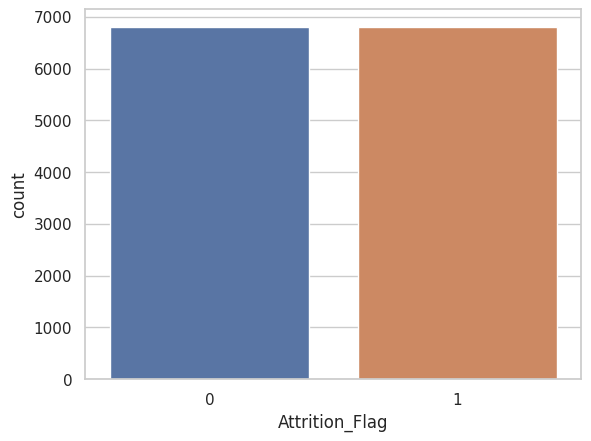

In [41]:
print('train : {}\ntest : {}'.format(Counter(y_train), Counter(y_test)))
print('Resampled dataset shape {}'.format(Counter(y_train)))
sns.set_theme(style="whitegrid")
sns.countplot(x= y_train)

**Encoder (Ordinal, Onehot) & SimpleImputer with 'Unknown' str**

In [42]:
# preparing each column for encoder
ordinal_cols = ['Income_Category', 'Education_Level']
nominal_cols = ['Gender']
cols_to_scale = ['Customer_Age',
                 'Dependent_count',
                'Months_on_book',
                'Total_Revolving_Bal',
                'Total_Trans_Amt',
                'Total_Trans_Ct',
                'Credit_Limit',
                'Avg_Open_To_Buy']

In [43]:
imp_enc = SimpleImputer(missing_values='Unknown', strategy='most_frequent')

ord_enc = OrdinalEncoder(categories=[
                ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'],
                ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']])

one_hot_enc = OneHotEncoder(handle_unknown='error', drop='if_binary')

ordinal_transformer = Pipeline(steps=[('unknown_imp', imp_enc), ('ordinal', ord_enc)])

numeric_transformer = Pipeline(steps=[('num_imp', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

nominal_transformer = Pipeline(steps=[('unknown_imp', imp_enc), ('one_hot', one_hot_enc)])

preprocessor = make_column_transformer((ordinal_transformer, ordinal_cols),
                                       (nominal_transformer, nominal_cols),
                                       (numeric_transformer, cols_to_scale),
                                       remainder = 'passthrough')

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

### **Logistic Regression** (Not using grid search)

In [45]:
# Logistic Regression
logreg = LogisticRegression()
# fit model
logreg.fit(X_train, y_train)
# confusion matrix
y_pred = logreg.predict(X_test)
cf = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(cf, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])
cr = classification_report(y_true=y_test, 
                                   y_pred = y_pred,
                                   target_names=['Existing Customer', 'Attrited Customer'])
print(cr)
print('Train Accuracy :',logreg.score(X_train, y_train))
print('Test Accuracy: ',logreg.score(X_test, y_test))

                   precision    recall  f1-score   support

Existing Customer       0.81      0.81      0.81      1703
Attrited Customer       0.81      0.80      0.81      1697

         accuracy                           0.81      3400
        macro avg       0.81      0.81      0.81      3400
     weighted avg       0.81      0.81      0.81      3400

Train Accuracy : 0.8138970588235294
Test Accuracy:  0.8061764705882353


**Performing K-Fold Cross Validation**

Mean of Accuracy for all  5  folds:  Accuracy:  0.8510034246157971
Mean of Precision  5  folds:  Precision:  0.881675367248328
Mean of Recall  5  folds:  Recall:  0.8510034246157971
Mean of Accuracy for all  6  folds:  Accuracy:  0.8609672305924594
Mean of Precision  6  folds:  Precision:  0.8859987536783261
Mean of Recall  6  folds:  Recall:  0.8609672305924594
Mean of Accuracy for all  7  folds:  Accuracy:  0.8619543026356953
Mean of Precision  7  folds:  Precision:  0.882596149218216
Mean of Recall  7  folds:  Recall:  0.8619543026356953
Mean of Accuracy for all  8  folds:  Accuracy:  0.8610596226014524
Mean of Precision  8  folds:  Precision:  0.8811109780032576
Mean of Recall  8  folds:  Recall:  0.8610596226014524
Mean of Accuracy for all  9  folds:  Accuracy:  0.8673959169352893
Mean of Precision  9  folds:  Precision:  0.8805046558247148
Mean of Recall  9  folds:  Recall:  0.8673959169352893


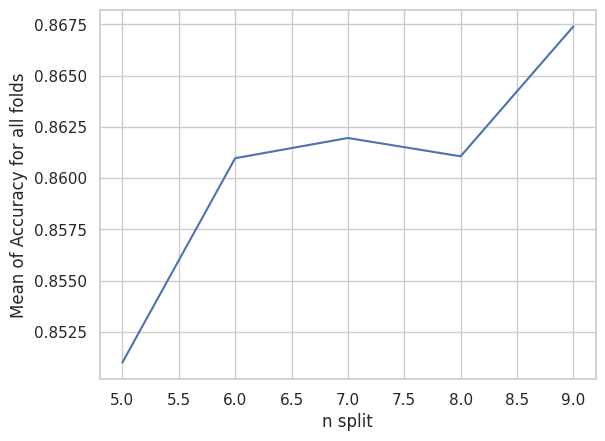

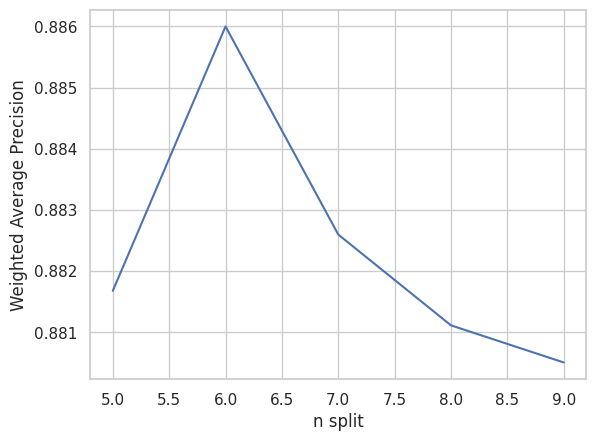

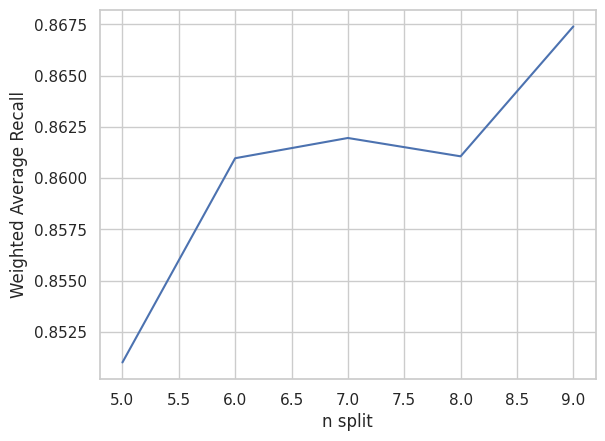

In [46]:
# K-folds Cross Validation
from sklearn.model_selection import cross_val_score

def cross_val_accuracy_precision(model, X, y):
    acc = []
    precisions=[]
    recalls=[]
    for n in range(5,10):

        # Note the results will vary each run since we take a different
        # subset of the data each time (since shuffle=True)
        scores = np.mean(cross_val_score(model, X, y, cv=n, scoring='accuracy'))
        acc.append(scores)
        p = np.mean(cross_val_score(model, X, y, cv=n, scoring=metrics.make_scorer(metrics.precision_score, average='weighted')))
        precisions.append(p)
        r = np.mean(cross_val_score(model, X, y, cv=n, scoring=metrics.make_scorer(metrics.recall_score, average='weighted')))
        recalls.append(r)
        print('Mean of Accuracy for all ', str(n), ' folds: ', 'Accuracy: ', scores)
        print('Mean of Precision ', str(n), ' folds: ', 'Precision: ', p)
        print('Mean of Recall ', str(n), ' folds: ', 'Recall: ', r)
        
    # plot to see clearly
    plt.plot(range(5,10), acc)
    plt.xlabel('n split')
    plt.ylabel('Mean of Accuracy for all folds')
    plt.show();
    plt.plot(range(5,10), precisions)
    plt.xlabel('n split')
    plt.ylabel('Weighted Average Precision')
    plt.show();
    plt.plot(range(5,10), recalls)
    plt.xlabel('n split')
    plt.ylabel('Weighted Average Recall')
    plt.show();

logreg_cv=LogisticRegression()
cross_val_accuracy_precision(logreg_cv, X, y)

**Parameter Tuning with GridSearch**

Gridsearch will find the best paramater, as there are plenty of parameters on the dataset.

## Logistic Regression (Using GridSearch)

In [47]:
# applied with Grid Search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , LogisticRegression())])


param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}]

clf = GridSearchCV(pipe, 
                   param_grid = param_grid, 
                   cv = 5, 
                   scoring=metrics.make_scorer(metrics.recall_score), # maximise recall to minimise FN
                   return_train_score=True,
                   n_jobs=-1,
                   verbose=True)
clf.fit(X, y)  
print(clf.best_estimator_)

clf_l = []

for i in range(10):

# Assign the best hyperparameter to model
  clf = LogisticRegression(C=545.5594781168514, penalty='l1', solver='liblinear')
  clf_s = cross_val_score(clf,X_train,y_train,cv=10).mean() 
  clf_l.append(clf_s)

# confusion matrix
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
cf = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(cf, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])
cr = classification_report(y_true=y_test, 
                                   y_pred = y_pred,
                                   target_names=['Existing Customer', 'Attrited Customer'])
print(cr)
print('Train Accuracy :',clf.score(X_train, y_train))
print('Test Accuracy: ',clf.score(X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Pipeline(steps=[('classifier',
                 LogisticRegression(C=206.913808111479, penalty='l1',
                                    solver='liblinear'))])
                   precision    recall  f1-score   support

Existing Customer       0.85      0.83      0.84      1703
Attrited Customer       0.83      0.85      0.84      1697

         accuracy                           0.84      3400
        macro avg       0.84      0.84      0.84      3400
     weighted avg       0.84      0.84      0.84      3400

Train Accuracy : 0.8551470588235294
Test Accuracy:  0.8408823529411765


Finding the feature importance

Feature 0: Income_Category, Score: -0.12098
Feature 1: Education_Level, Score: -0.07916
Feature 2: Gender, Score: -0.09650
Feature 3: Customer_Age, Score: -0.01702
Feature 4: Dependent_count, Score: -0.07816
Feature 5: Months_on_book, Score: -0.00326
Feature 6: Total_Relationship_Count, Score: -0.64240
Feature 7: Months_Inactive_12_mon, Score: 0.34461
Feature 8: Contacts_Count_12_mon, Score: 0.30852
Feature 9: Total_Revolving_Bal, Score: -0.00080
Feature 10: Total_Amt_Chng_Q4_Q1, Score: -0.58474
Feature 11: Total_Trans_Amt, Score: 0.00052
Feature 12: Total_Trans_Ct, Score: -0.13196
Feature 13: Total_Ct_Chng_Q4_Q1, Score: -3.06413
Feature 14: Avg_Utilization_Ratio, Score: -0.03988


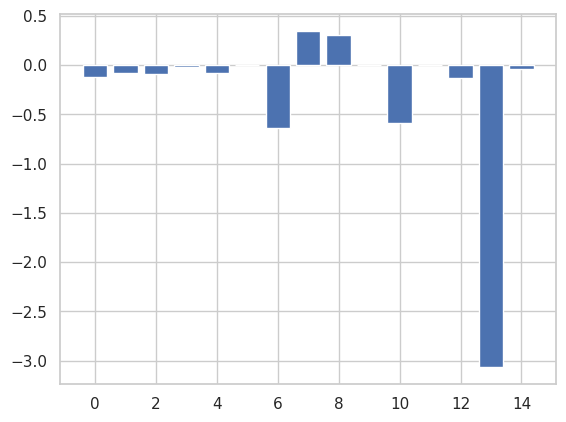

In [48]:
from matplotlib import pyplot
importance = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature %0d: %s, Score: %.5f' % (i,X_train.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [49]:
# The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

## Support Vector Machine

In [50]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn import neighbors

In [51]:
# finding the best kernel for the model
record_index=0 
record=np.zeros(3) 
accuracy_score_Records = []

for kernel in ['linear','poly','rbf']:
  clf_SVM = svm.SVC(kernel=kernel, degree=3)
  clf_SVM.fit(X, y)
  y_pred = clf_SVM.predict(X_test) 
  record[record_index]=accuracy_score(y_test, y_pred) 
  record_index=record_index+1 
  accuracy_score_Records.append(record)
accuracy_score_Records=np.array(accuracy_score_Records)

print(f" kNN 'linear','poly','rbf'\n{accuracy_score_Records.mean(axis=0)}")

 kNN 'linear','poly','rbf'
[0.74264706 0.50088235 0.71735294]


In [52]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_SVM = {'C': [0.1], 
              'gamma': [1, 0.1],
              'kernel': ['rbf']} 

clf_SVM = GridSearchCV(SVC(), 
                   param_grid = param_grid_SVM, 
                   cv = 5, 
                   scoring=metrics.make_scorer(metrics.recall_score), # maximise recall to minimise FN
                   return_train_score=True,
                   n_jobs=-1,
                   verbose=True)
clf_SVM.fit(X, y)
print(clf_SVM.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVC(C=0.1, gamma=1)


In [53]:
list_of_score_SVM = []

for i in range(10):

# Assign the best parameter to model
  best_clf_SVM = SVC()
  k_score_SVM = cross_val_score(best_clf_SVM,X_train,y_train,cv=3).mean() 
  list_of_score_SVM.append(k_score_SVM)
print(list_of_score_SVM)
# confusion matrix
best_clf_SVM.fit(X_train,y_train)
y_pred_SVM = best_clf_SVM.predict(X_test)
cf_SVM = metrics.confusion_matrix(y_test, y_pred_SVM)
pd.DataFrame(cf_SVM, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])
cr_SVM = classification_report(y_true=y_test, 
                                   y_pred = y_pred_SVM,
                                   target_names=['Existing Customer', 'Attrited Customer'])
print(cr_SVM)
print('Train Accuracy :',best_clf_SVM.score(X_train, y_train))
print('Test Accuracy: ',best_clf_SVM.score(X_test, y_test))

[0.7833090914953171, 0.7833090914953171, 0.7833090914953171, 0.7833090914953171, 0.7833090914953171, 0.7833090914953171, 0.7833090914953171, 0.7833090914953171, 0.7833090914953171, 0.7833090914953171]
                   precision    recall  f1-score   support

Existing Customer       0.83      0.75      0.79      1703
Attrited Customer       0.77      0.84      0.80      1697

         accuracy                           0.80      3400
        macro avg       0.80      0.80      0.80      3400
     weighted avg       0.80      0.80      0.80      3400

Train Accuracy : 0.7950735294117647
Test Accuracy:  0.7961764705882353


The result SVM:
* Accuracy - 80
* Precision - 83
* Recall - 75
* F-1 Score - 79

The result is not good enough

## **Comparing (Decision Tree & Random Forrest)**

In [54]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt 
import time


dt_clf = DecisionTreeClassifier(random_state=0)

dt_clf = clf.fit(X,y)
# confusion matrix (DT)
dt_clf.fit(X_train,y_train)
y_pred = dt_clf.predict(X_test)
cf = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(cf, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])
cr = classification_report(y_true=y_test, 
                                   y_pred = y_pred,
                                   target_names=['Existing Customer', 'Attrited Customer'])
print(cr)
print('Train Accuracy :',dt_clf.score(X_train, y_train))
print('Test Accuracy: ',dt_clf.score(X_test, y_test))

rfc = RandomForestClassifier(random_state=0)

rfc = rfc.fit(X,y)

# confusion matrix (RF)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
cf = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(cf, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])
cr = classification_report(y_true=y_test, 
                                   y_pred = y_pred,
                                   target_names=['Existing Customer', 'Attrited Customer'])
print(cr)

score_c = dt_clf.score(X_test,y_test) 
score_r = rfc.score(X_test,y_test) 
print("Decision Tree:{}".format(score_c),"Random Forest:{}".format(score_r))
print('Train Accuracy :',rfc.score(X_train, y_train))
print('Test Accuracy: ',rfc.score(X_test, y_test))

                   precision    recall  f1-score   support

Existing Customer       0.85      0.83      0.84      1703
Attrited Customer       0.83      0.85      0.84      1697

         accuracy                           0.84      3400
        macro avg       0.84      0.84      0.84      3400
     weighted avg       0.84      0.84      0.84      3400

Train Accuracy : 0.8552941176470589
Test Accuracy:  0.8408823529411765
                   precision    recall  f1-score   support

Existing Customer       0.98      0.96      0.97      1703
Attrited Customer       0.97      0.98      0.97      1697

         accuracy                           0.97      3400
        macro avg       0.97      0.97      0.97      3400
     weighted avg       0.97      0.97      0.97      3400

Decision Tree:0.8408823529411765 Random Forest:0.9735294117647059
Train Accuracy : 1.0
Test Accuracy:  0.9735294117647059


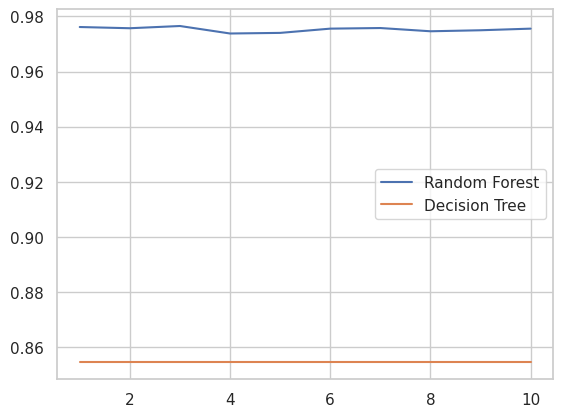

In [55]:
# plot graph to compare the accuracy between decision tree and random forrest
rfc_l = []

dt_clf_l = []

for i in range(10):

  rfc = RandomForestClassifier(n_estimators=25)
  rfc_s = cross_val_score(rfc,X_train,y_train,cv=10).mean() 
  rfc_l.append(rfc_s) 
  dt_clf = DecisionTreeClassifier() 
  dt_clf_s = cross_val_score(clf,X_train,y_train,cv=10).mean() 
  dt_clf_l.append(clf_s)
plt.plot(range(1,11),rfc_l,label = "Random Forest") 
plt.plot(range(1,11),dt_clf_l,label = "Decision Tree") 
plt.legend()
plt.show()

In [56]:
rfc_best = RandomForestClassifier(n_estimators=21,n_jobs=-1,random_state=90) 
rfc_best = rfc_best.fit(X_train,y_train) 


y_pred_rf = rfc_best.predict(X_test)
cf_rf = metrics.confusion_matrix(y_test, y_pred_rf)
pd.DataFrame(cf_rf, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])
cr_rf = classification_report(y_true=y_test, 
                                   y_pred = y_pred_rf,
                                   target_names=['Existing Customer', 'Attrited Customer'])
print(cr_rf)
print('Train Accuracy :',rfc_best.score(X_train, y_train))
print('Test Accuracy: ',rfc_best.score(X_test, y_test))

                   precision    recall  f1-score   support

Existing Customer       0.98      0.96      0.97      1703
Attrited Customer       0.96      0.98      0.97      1697

         accuracy                           0.97      3400
        macro avg       0.97      0.97      0.97      3400
     weighted avg       0.97      0.97      0.97      3400

Train Accuracy : 0.9995588235294117
Test Accuracy:  0.9705882352941176


In [57]:
pd.DataFrame(cf_rf, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])

,(Predict)Negative,(Predict)Positive
[Actual] Negative,1639,64
[Actual] Positive,36,1661


**Create the plot to visualise the feature importance**

In [58]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  pal = sns.color_palette("viridis",)
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],palette = pal)
  #Add chart labels
  plt.title(model_type + ' ' + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

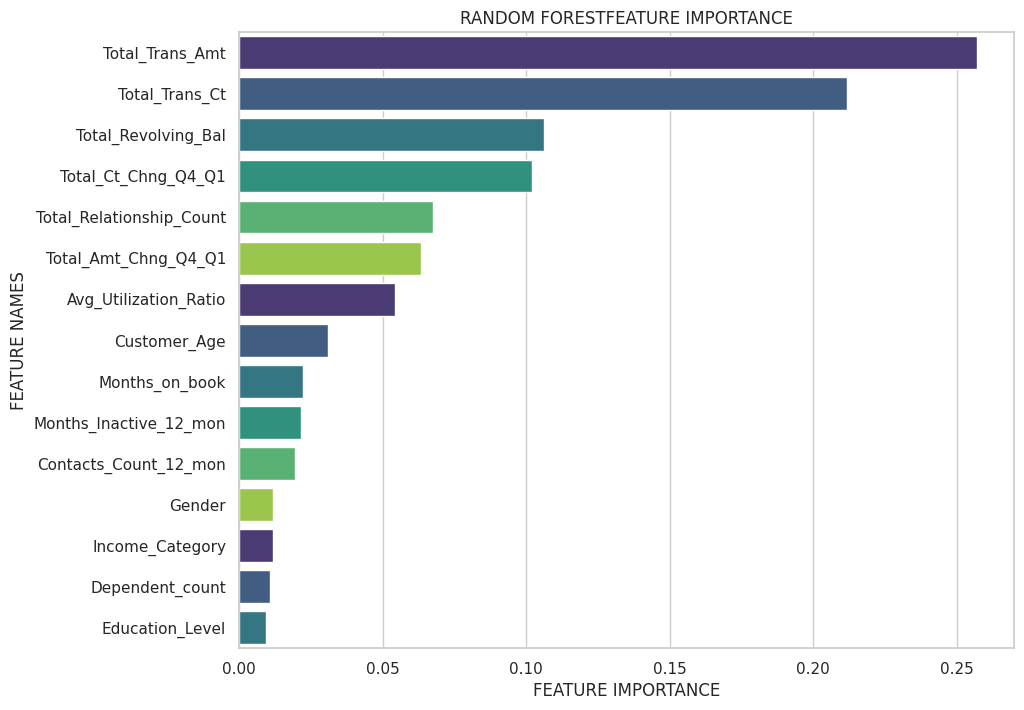

In [59]:
plot_feature_importance(rfc_best.feature_importances_,X_train.columns,'RANDOM FOREST')

In [60]:
X_train.columns[rfc_best.feature_importances_ >= np.mean(rfc_best.feature_importances_)]

Index(['Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1'],
      dtype='object')

As, the random forrest has the highest accuracy so far. Hence, the feature imporatance of this model is important to analyse the features.

## **Adaboost Model**

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# ADaboost model
m_adb = AdaBoostClassifier(n_estimators=100,learning_rate = 1.0
                       , random_state=42)

#Train the model using the training sets
m_adb.fit(X,y)

# confusion matrix (DT)
m_adb.fit(X_train,y_train)
y_pred = m_adb.predict(X_test)
cf = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(cf, columns=['(Predict)Negative','(Predict)Positive'], index=['[Actual] Negative','[Actual] Positive'])
cr = classification_report(y_true=y_test, 
                                   y_pred = y_pred,
                                   target_names=['Existing Customer', 'Attrited Customer'])
print(cr)
print('Train Accuracy :',m_adb.score(X_train, y_train))
print('Test Accuracy: ',m_adb.score(X_test, y_test))

                   precision    recall  f1-score   support

Existing Customer       0.96      0.94      0.95      1703
Attrited Customer       0.94      0.96      0.95      1697

         accuracy                           0.95      3400
        macro avg       0.95      0.95      0.95      3400
     weighted avg       0.95      0.95      0.95      3400

Train Accuracy : 0.9630147058823529
Test Accuracy:  0.9514705882352941
